# Using GPU

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
assert device_name == '/device:GPU:0'
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet

In [3]:
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: GeForce GTX 1080 Ti


# Import dataset

In [9]:
import numpy as np
import pandas as pd

# Load 140k dataset
df = pd.read_csv('data/test.tsv', sep='\t', header=None)
df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df)))

Number of data entries: 125412


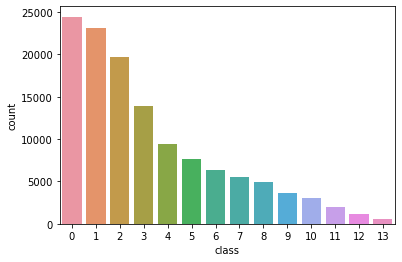

In [10]:
# Label Encdoing
class_map={'科技':0, '股票':1, '体育':2, '娱乐':3, '时政':4,
          '社会':5, '教育':6, '财经':7, '家居':8, '游戏':9,
          '房产':10, '时尚':11,'彩票':12, '星座':13}

# Mapping the class names
df['class'] = df['class'].map(class_map)

# Show class countplot
import seaborn as sns
sns.countplot(df['class'])

In [11]:
# Display 5 random rows from the data
df.sample(5)

,class,text
63117,2,德媒叹息邵佳一错失良机 不满主帅错误安排害了他 新浪体育讯 在北京时间5月16日晚结束的德...
75988,0,沈皓瑜解读切换凤巢引发收入下降用户还不会玩 新浪科技讯 11月13日消息，百度商业运营副总...
19718,6,图文：高端访谈来宾加成移民孙利军 2011年5月17日，新浪教育频道邀全国移民行业最具影响...
106621,1,马化腾：网游增长率将下降 望投资者关注长线 新浪科技讯 3月17日晚间消息 腾讯控股去年净...
113968,2,国足因何两天内两大将受伤 连日下雨都是草皮惹祸 新浪体育讯 国家队此次昆明集训，原本只有队...


# Train, valid and test split

In [12]:
from sklearn.model_selection import train_test_split

# Extra 70% for training
df_train, df_val = train_test_split(df,
                                    test_size=0.3,
                                    random_state=1,
                                    stratify=df['class'])

# Extra 20% for validation
df_val, df_test = train_test_split(df_val,
                                    test_size=0.333333,
                                    random_state=1,
                                    stratify=df_val['class'])

Shape: (87788, 2)
Shape: (25082, 2)
Shape: (12542, 2)


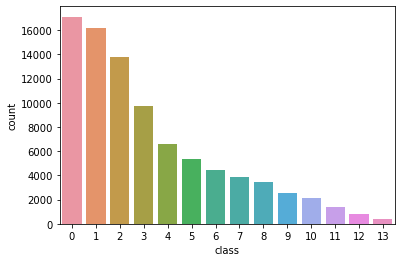

In [13]:
for item in df_train, df_val, df_test:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution    
sns.countplot(df_train['class'])

# Tokenization

In [14]:
!pip install transformers --quiet

ERROR: tensorlayer 2.1.0 has requirement numpy<1.17,>=1.16, but you'll have numpy 1.21.1 which is incompatible.


In [15]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [16]:
# Create lists for encoded text data
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['text']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        max_length=128,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [17]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

# Dataset and DataLoader

In [18]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['class'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [19]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)
test_dataloader = get_dataloader(df_test)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Import BERT model

In [20]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-chinese',
                                                      num_labels=len(df['class'].unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

In [22]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

# Training

In [23]:
# Import materics for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [24]:
# Reset history lists
history_training_loss = []
history_val_loss = []
history_val_acc = []

for epoch_i in range(epochs):
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0.
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    # append the loss data to history
    history_training_loss.append(avg_train_loss)
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # append validation data to history
    history_val_acc.append(acc)
    history_val_loss.append(avg_val_loss)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    print('\n')

【EPOCH: 1/ 10】
Trainig Phase
  Average training loss: 0.2466
Validation Phase
  Average validation loss: 0.1719
  Validation accruacy: 0.9512


【EPOCH: 2/ 10】
Trainig Phase
  Average training loss: 0.1246
Validation Phase
  Average validation loss: 0.1810
  Validation accruacy: 0.9511


【EPOCH: 3/ 10】
Trainig Phase
  Average training loss: 0.0781
Validation Phase
  Average validation loss: 0.1835
  Validation accruacy: 0.9578


【EPOCH: 4/ 10】
Trainig Phase
  Average training loss: 0.0479
Validation Phase
  Average validation loss: 0.2124
  Validation accruacy: 0.9577


【EPOCH: 5/ 10】
Trainig Phase
  Average training loss: 0.0296
Validation Phase
  Average validation loss: 0.2475
  Validation accruacy: 0.9559


【EPOCH: 6/ 10】
Trainig Phase
  Average training loss: 0.0171
Validation Phase
  Average validation loss: 0.2827
  Validation accruacy: 0.9573


【EPOCH: 7/ 10】
Trainig Phase
  Average training loss: 0.0097
Validation Phase
  Average validation loss: 0.2950
  Validation accruacy: 0

# Training and evaluation performance

In [25]:
# Convert histroy to dataframe
cols = ['loss', 'val_loss', 'val_acc']

history = np.stack((
                    np.array(history_training_loss),        
                    np.array(history_val_loss),
                    np.array(history_val_acc),
                    ), axis=1)

df_history = pd.DataFrame(history, columns=cols)

# Show df_history
df_history

,loss,val_loss,val_acc
0,0.246556,0.171889,0.951160
1,0.124580,0.180976,0.951120
2,0.078133,0.183501,0.957818
3,0.047852,0.212399,0.957739
4,0.029566,0.247465,0.955865
5,0.017087,0.282691,0.957260
6,0.009657,0.294998,0.956981
7,0.006490,0.302113,0.958895
8,0.002749,0.328253,0.959852
9,0.001043,0.328081,0.959413


Text(0.5, 1.0, 'accuracy')

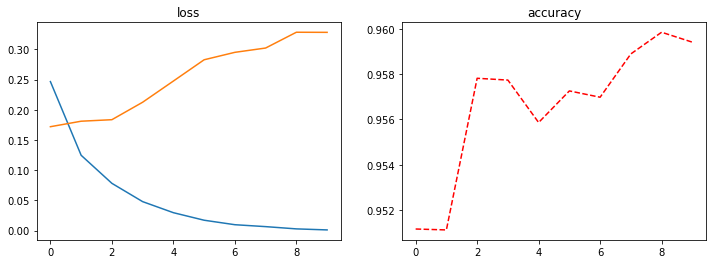

In [26]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_history['loss'])
plt.plot(df_history['val_loss'])
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(df_history['val_acc'], color='red', linestyle='--')
plt.title('accuracy')

# Perform on the test data

In [27]:
# Setup lists for predictions and labels
ls_test_pred = []
ls_test_labels = []


# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits

        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        test_labels = b_labels.cpu().detach().numpy() 
        
        for pred in test_logits:
            ls_test_pred.append(pred)
        
        for label in test_labels:
            ls_test_labels.append(label)
        
#Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))

Prediction accuracy: 0.9620


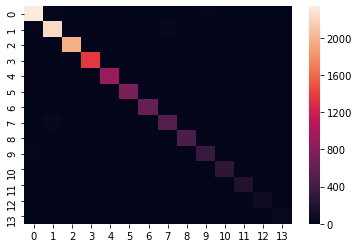

In [28]:
# Confusion matrix
cm = confusion_matrix(ls_test_pred, ls_test_labels)

sns.heatmap(cm)

In [29]:
# Classification report
cr = classification_report(ls_test_pred, ls_test_labels)

print(cr)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2426
           1       0.96      0.97      0.96      2311
           2       0.99      0.99      0.99      1990
           3       0.98      0.98      0.98      1397
           4       0.95      0.93      0.94       967
           5       0.94      0.94      0.94       760
           6       0.96      0.96      0.96       632
           7       0.91      0.92      0.92       552
           8       0.94      0.97      0.96       473
           9       0.94      0.93      0.94       368
          10       0.94      0.92      0.93       307
          11       0.97      0.97      0.97       199
          12       0.92      0.97      0.95       108
          13       0.98      1.00      0.99        52

    accuracy                           0.96     12542
   macro avg       0.95      0.96      0.96     12542
weighted avg       0.96      0.96      0.96     12542



# Export training history

In [26]:
df_history.to_csv('history/2000samples.csv')

In [27]:
df_history

,loss,val_loss,val_acc
0,2.190455,1.346256,0.819231
1,0.843875,0.577351,0.919231
2,0.332723,0.320184,0.942308
3,0.147227,0.381489,0.930769
4,0.076441,0.251537,0.930769
5,0.046936,0.265561,0.938462
6,0.026859,0.277572,0.942308
7,0.019212,0.284532,0.930769
8,0.016289,0.277528,0.938462
9,0.015005,0.266562,0.938462


# Saving the model

In [33]:
model_path = 'model/125_baseline.pt'

torch.save(model.state_dict(), model_path)